# AWESim SOSS

**Advanced Webb Exposure Simulator for SOSS**

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy.units as q
import astropy.constants as ac
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
import batman
from pkg_resources import resource_filename
from awesimsoss import awesim
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

## M Dwarf (no planet)
Here is how to generate time series observations of a brown dwarf (or any other isolated star with no transiting planet).

We need two components to generate this simulation:
- A flux calibrated stellar spectrum
- A specified number of integrations and groups for the observation

Let's use this 3500K stellar spectrum with a J magnitude of 9.

Text(0, 0.5, 'Flux Density [$\\rm erg/s/cm^2/A$]')

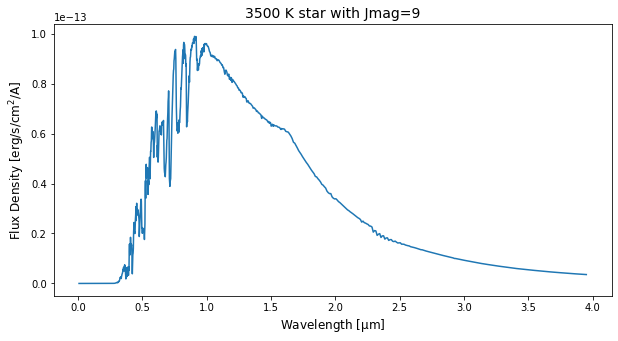

In [3]:
# Get the wavelength and flux of the star with units 
star = np.genfromtxt(resource_filename('awesimsoss','files/scaled_spectrum.txt'), unpack=True)
star1D = [star[0]*q.um, (star[1]*q.W/q.m**2/q.um).to(q.erg/q.s/q.cm**2/q.AA)]  
star1D = [i[:1000] for i in star1D] 

# Plot it
f, ax = plt.subplots(figsize=(10,5))
ax.plot(star1D[0], star1D[1])
ax.set_title('3500 K star with Jmag=9', fontsize=14)
ax.set_xlabel(r'Wavelength [$\rm \mu m$]', fontsize=12)
ax.set_ylabel(r'Flux Density [$\rm erg/s/cm^2/A$]', fontsize=12)

Now we can intialize the simulation by passing the number of groups (3) and integrations (10) along with the stellar spectrum to the `TSO` class.

In [4]:
# Initialize the simulation with 3 groups and 10 integrations
my_TSO = awesim.TSO(ngrps=3, nints=10, star=star1D, target='WASP-107')  

Coordinates 188.38684999999998 -10.146173055555556 for 'WASP-107' found in Simbad!


In [5]:
# Run the simulation - takes ~1 minute
my_TSO.simulate()

Calculating order 1 light curves...
Lightcurves finished: 28.421 s
Constructing order 1 traces...
Order 1 traces finished: 1.726 s
Calculating order 2 light curves...
Lightcurves finished: 22.441 s
Constructing order 2 traces...
Order 2 traces finished: 1.65 s
Adding noise to TSO...
Noise model finished: 3.855 s

Total time: 59.351 s


We can view frames of the simulation with the `plot` method like so:

In [ ]:
# plot the TSO object 
my_TSO.plot()  

We can also take a look at the extracted spectrum (simple column sum for now) for a given frame with the `plot_spectrum` like so:

In [6]:
my_TSO.plot_spectrum(frame=13, scale='linear', order=1, noise=False)

## M Dwarf (with planet)
Let's pretend this M dwarf is orbited by WASP107b! Why not? First get the transmission spectrum:

(0, 4)

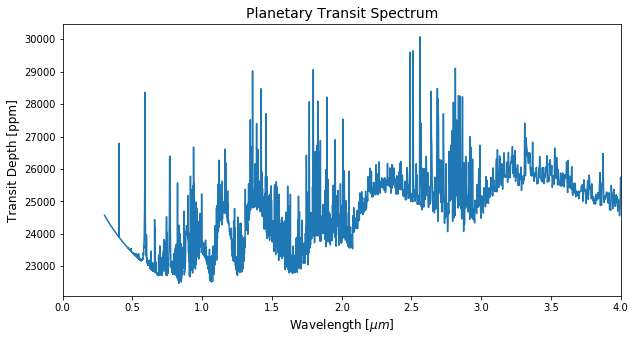

In [7]:
# Get the planet data - comes with the awesimsoss installation
planet_file = resource_filename('awesimsoss', '/files/WASP107b_pandexo_input_spectrum.dat')
planet = np.genfromtxt(planet_file, unpack=True)
planet1D = [planet[0]*q.um, planet[1]]

# Plot it
f, ax = plt.subplots(figsize=(10,5))
ax.plot(planet1D[0], planet1D[1]*1000000)
ax.set_title('Planetary Transit Spectrum', fontsize=14)
ax.set_xlabel(r'Wavelength [$\mu m$]', fontsize=12)
ax.set_ylabel('Transit Depth [ppm]', fontsize=12)
ax.set_xlim(0,4)

In [8]:
# Set the orbital parameters with the Batman package (https://www.cfa.harvard.edu/~lkreidberg/batman/quickstart.html)
params = batman.TransitParams()
params.t0 = 0.001               # Time of inferior conjunction (days)
params.per = 0.03               # Orbital period (days)
params.rp = 0.15                # Planet radius (in units of R*)
params.a = 0.0558*q.AU.to(ac.R_sun)*0.66                  # Semi-major axis (in units of R*)
params.inc = 89.8               # Orbital inclination (in degrees)
params.ecc = 0.                 # Eccentricity
params.w = 90.                  # Longitude of periastron (in degrees) 
params.u = [0.1, 0.1]           # Limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"  # Limb darkening model

# Make the transit model and add the stellar params
day2sec = 86400
tmodel = batman.TransitModel(params, my_TSO.time/day2sec)  # Make sure to work in days!
tmodel.teff = 3500              # Effective temperature of the host star
tmodel.logg = 5                 # log surface gravity of the host star
tmodel.feh = 0                  # Metallicity of the host star

Text(0, 0.5, 'Relative Flux')

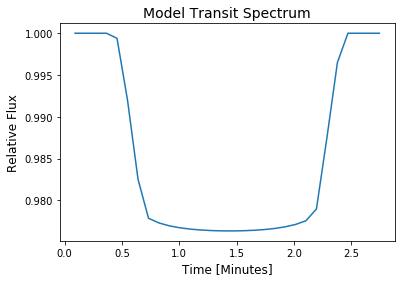

In [15]:
# Visualize the transit
flux = tmodel.light_curve(params)

plt.plot(my_TSO.time/60, flux)
plt.title('Model Transit Spectrum', fontsize=14)
plt.xlabel('Time [Minutes]', fontsize=12)
plt.ylabel('Relative Flux', fontsize=12)

In [11]:
# Run the simulation, this time including the planet - takes ~1 minute
my_TSO.simulate(planet=planet1D, tmodel=tmodel)

Please set a stellar intensity model grid with the 'model_grid' attribute to update the limb darkening coefficients
Calculating order 1 light curves...
Lightcurves finished: 23.07 s
Constructing order 1 traces...
Order 1 traces finished: 1.525 s
Calculating order 2 light curves...
Lightcurves finished: 22.454 s
Constructing order 2 traces...
Order 2 traces finished: 1.624 s
Adding noise to TSO...
Noise model finished: 3.572 s

Total time: 53.511 s


And we can see the spectroscopic lightcurves with the `plot_lightcurve` method like so:

In [12]:
# Plot the lightcurves
my_TSO.plot_lightcurve(column=[1700, 1600, 1800], time_unit='min')

## Exporting Results

Create a fits file with your time series observations with ``export`` like so:

In [6]:
my_TSO.export('my_soss_simulation.fits')

File saved as ng2ni1.fits
